# Oppgave 1

### Visualisering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sympy as sm
from scipy.integrate import solve_ivp

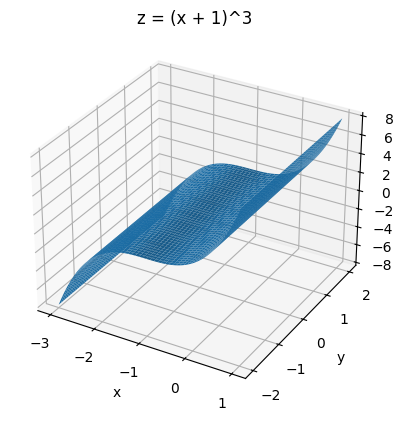

In [2]:
# Lag grid
x = np.linspace(-3, 1, 200)
y = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x, y)

# Funksjon
Z = (X + 1)**3

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("z = (x + 1)^3")

plt.show()


### Løsning

In [3]:
def newton(t, x0, f, Jf, TOL=1e-6, MAX_ITER=100, should_log=False):
    x = x0
    err = np.inf
    i = 0
    while err > TOL and i < MAX_ITER:
        G = f(t, x)
        J = Jf(t, x)
        dx = np.linalg.solve(J,-G).squeeze()
        if should_log: print(dx)
        x += dx
        err = np.linalg.norm(dx)
        i += 1
    return x

time = sm.symbols("t")
x1, x2, x3 = sm.symbols("x_1 x_2 x_3")
state = sm.Matrix([x1, x2, x3])
f_sym = sm.Matrix([(x1 + 1)**3, (x2 + 1)**3, (x3 + 1)**3])
Jf_sym = f_sym.jacobian(state)
f = sm.lambdify([time, state], f_sym, "numpy")
Jf = sm.lambdify([time, state], Jf_sym, "numpy")

solution = newton([0], [0,0,0], f, Jf)
print(solution)

[-0.99999897 -0.99999897 -0.99999897]


# Oppgave 2

Test eval: f(0, (1,0)) = 
[[ 0]
 [-1]]
Test eval: Jf(0, (1,0)) = 
[[ 0  1]
 [-1  0]]


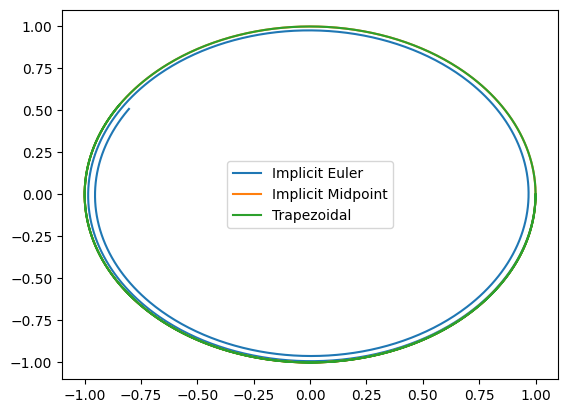

In [4]:
omega = 1
t, x, v = sm.symbols("t, x, v")
state = sm.Matrix([x, v])
_f = sm.Matrix([v,-omega**2 * x])
_Jf = _f.jacobian(state)
f = sm.lambdify([t, state], _f, "numpy")
Jf = sm.lambdify([t, state], _Jf, "numpy")
print(f"Test eval: f(0, (1,0)) = \n{f(0, [1, 0])}")
print(f"Test eval: Jf(0, (1,0)) = \n{Jf(0, [1, 0])}")


# Main simulation loop
def simulate_with_stepper(x0: np.ndarray, t0, tf, h, stepper):
    n = int((tf-t0)//h) + 1
    ts = np.array([i*h for i in range(n)])
    xs = np.zeros((2, n))
    xs[:, 0] = x0
    for i in range(1, n):
        xs[:, i] = stepper(ts[i-1], xs[:, i-1], h)
    return ts, xs

def implicit_euler_step(tn, xn, h):
    x = xn.copy()
    res = lambda t, x: x- xn- h*f(t, x).squeeze()
    res_jac = lambda t, x: np.eye(len(x))- h * Jf(t, x).squeeze()
    return newton(tn+h, x, res, res_jac)

# Solver configuration, initial conditions
ics = (1, 0)
t0, tf = 0, 10
h = 0.01

# Numerical solution
ts_ie, xs_ie = simulate_with_stepper(np.array(ics), t0, tf, h, implicit_euler_step)

def implicit_midpoint_step(tn, xn, h):
    x = xn.copy()
    res = lambda t, x: x- xn- h * f(t+h/2, (xn + x)/2).squeeze()
    res_jac = lambda t, x: np.eye(len(x))- h/2 * Jf(t+h/2, (xn+x)/2).squeeze()
    return newton(tn, x, res, res_jac)

# Solver configuration, initial conditions
ics = (1, 0)
t0, tf = 0, 10
h = 0.01

# Numerical solution
ts_im, xs_im = simulate_with_stepper(np.array(ics), t0, tf, h, implicit_midpoint_step)

def trapezoidal_step(tn, xn, h):
    x = xn.copy()
    fn = f(tn, xn).squeeze()
    res = lambda t, x: x- xn- h/2 *fn- h/2 * f(t, x).squeeze()
    res_jac = lambda t, x: np.eye(len(x))- h/2 * Jf(t, x).squeeze()
    return newton(tn+h, x, res, res_jac)

# Solver configuration, initial conditions
ics = (1, 0)
t0, tf = 0, 10
h = 0.01

# Numerical solution
ts_tr, xs_tr = simulate_with_stepper(np.array(ics), t0, tf, h, trapezoidal_step)

plt.plot(xs_ie[0, :], xs_ie[1, :], label="Implicit Euler")
plt.plot(xs_im[0, :], xs_im[1, :], label="Implicit Midpoint")
plt.plot(xs_tr[0, :], xs_tr[1, :], label="Trapezoidal")
plt.legend()
plt.show()

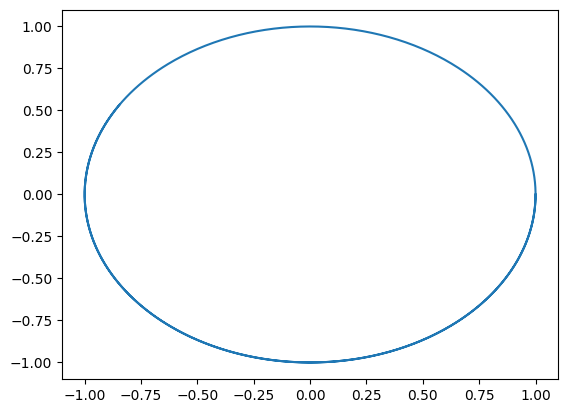

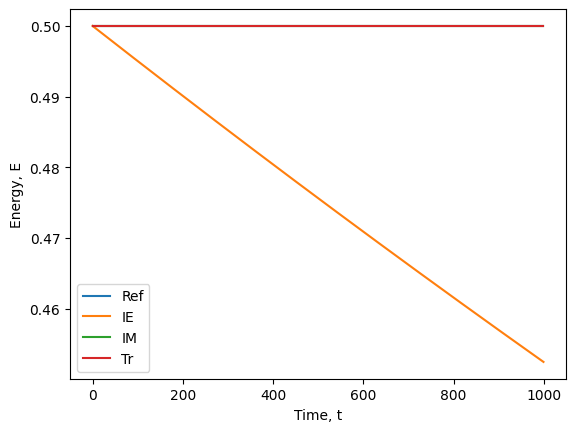

          Impl. Euler  Impl. Midpoint  Trapezoidal
0.001000          inf             inf          inf
0.000500     0.999323        1.999458     1.999458
0.000250     0.999662        1.999729     1.999729
0.000125     0.999831        1.999866     1.999866
0.000063     0.999915        1.999944     1.999944


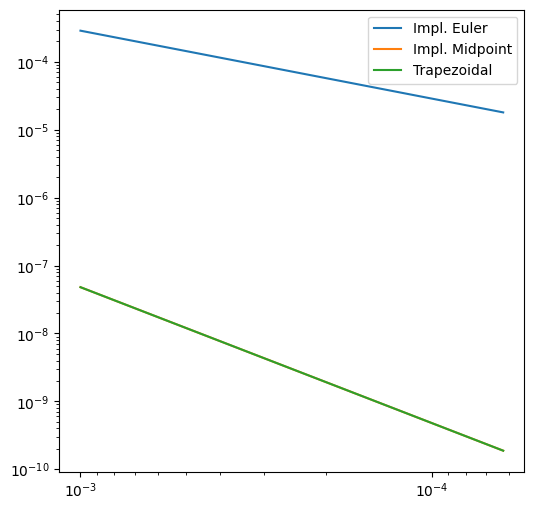

In [5]:
def analytical_solution(ts, omega):
    return np.array([np.cos(omega * ts),- omega * np.sin(omega * ts)])

ref_sol = analytical_solution(ts_ie, omega)
plt.plot(ref_sol[0, :], ref_sol[1, :]); plt.show()

def energy(x, v, omega):
    return 1/2 * omega**2 * x**2 + 1/2 * v**2

plt.plot(energy(ref_sol[0, :], ref_sol[1, :], omega), label="Ref")
plt.plot(energy(xs_ie[0, :], xs_ie[1, :], omega), label="IE")
plt.plot(energy(xs_im[0, :], xs_im[1, :], omega), label="IM")
plt.plot(energy(xs_tr[0, :], xs_tr[1, :], omega), label="Tr")
# plt.ylim(.5-1e-15, .5 + 1e-15) # Enable to better see how well the other methods do
plt.legend(); plt.xlabel("Time, t"); plt.ylabel("Energy, E")
plt.show()

def compute_error(my_sol, ref_sol, h):
    return np.sqrt(np.sum(h * np.linalg.norm(np.abs(ref_sol- my_sol), axis=0)**2))

def compute_eoc(errors, hs):
    eocs = [np.inf]
    for i in range(1, len(errors)):
        eocs.append(np.log(errors[i-1] / errors[i]) / np.log(hs[i-1] / hs[i]))
    return eocs

def compare_stepper(t0, tf, hs, stepper, ics):
    errors = []
    for h in hs:
        _ts, _sol = simulate_with_stepper(np.array(ics), t0, tf, h, stepper)
        _ref = analytical_solution(_ts, omega)
        errors.append(compute_error(_sol, _ref, h))
    
    eocs = compute_eoc(errors, hs)
    
    return errors, eocs

err_ie, eoc_ie = compare_stepper(t0, 1, [.5, .25, .125, .0625], implicit_euler_step, ics)
err_im, eoc_im = compare_stepper(t0, 1, [.5, .25, .125, .0625], implicit_midpoint_step, ics)
err_tr, eoc_tr = compare_stepper(t0, 1, [.5, .25, .125, .0625], trapezoidal_step, ics)

import pandas as pd

names = ["Impl. Euler", "Impl. Midpoint", "Trapezoidal"]
steppers = [implicit_euler_step, implicit_midpoint_step, trapezoidal_step]
hs = [.001 / 2**i for i in range(5)]
eoc_df = pd.DataFrame(index=hs)
plt.figure(figsize=(6,6))
for name, stepper in zip (names, steppers):
    _errs, _eocs = compare_stepper(t0, 1, hs, stepper, ics)
    plt.loglog(hs, _errs, label=name)
    eoc_df[name] = _eocs

print(eoc_df)
plt.gca().invert_xaxis()
plt.legend()
plt.show()

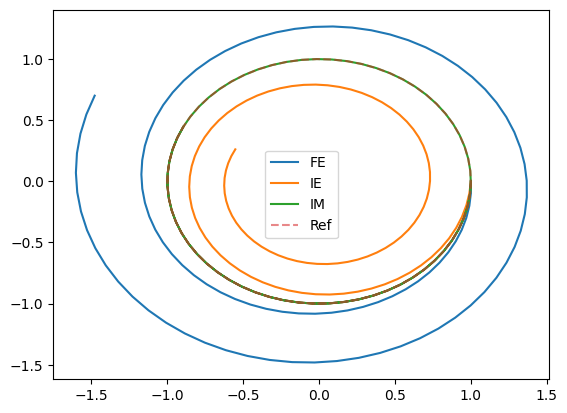

In [6]:
def forward_euler_step(tn, yn, h)-> np.ndarray:
    return yn + h * f(tn, yn).squeeze()
ts_fe, xs_fe = simulate_with_stepper(np.array([1, 0]), 0, 10, .1, forward_euler_step)
ts_be, xs_be = simulate_with_stepper(np.array([1, 0]), 0, 10, .1, implicit_euler_step) # Implicit Euler is also called Backward Euler
ts_im, xs_im = simulate_with_stepper(np.array([1, 0]), 0, 10, .1, implicit_midpoint_step) 
xs_an = analytical_solution(ts_im, 1)

plt.plot(xs_fe[0, :], xs_fe[1, :], label="FE")
plt.plot(xs_be[0, :], xs_be[1, :], label="IE")
plt.plot(xs_im[0, :], xs_im[1, :], label="IM")
plt.plot(xs_an[0, :], xs_an[1, :], linestyle="--", alpha=.55, label="Ref")
plt.legend(); plt.show()

### Problem 3 - Stability and stiff systems

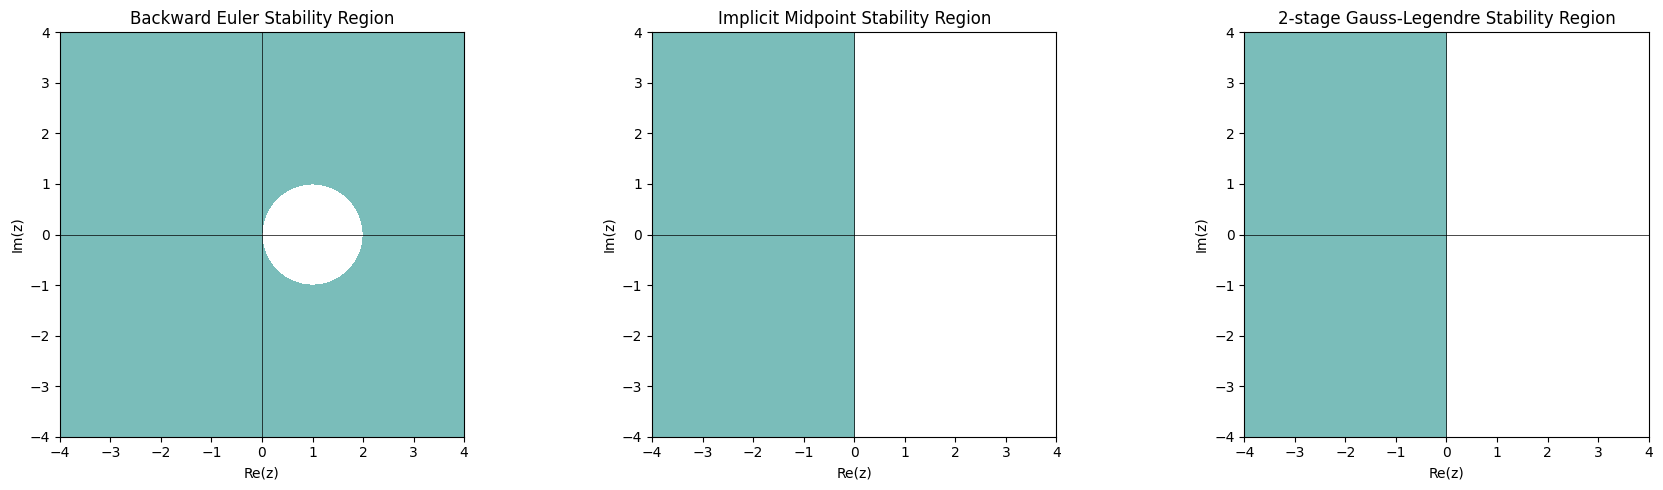

In [7]:
def R_backward_euler(z):
    return 1 / (1- z)

def R_implicit_midpoint(z):
    return (1 + z/2) / (1- z/2)

## Stability function of the 2-stage Gauss-Legendre method
def R_GLRK_two_stage(z):
    return (1 + z/2 + z**2/12) / (1- z/2 + z**2/12)

def plot_region(ax, R, title):
    # Complex grid
    re = np.linspace(-4, 4, 800)
    im = np.linspace(-4, 4, 800)
    Re, Im = np.meshgrid(re, im)
    z = Re + 1j * Im
    stability = np.abs(R(z))
    
    # Plot
    ax.contourf(Re, Im, stability, levels = [0, 1], alpha=0.6, cmap="viridis")
    ax.axhline(0, color="black", linewidth=0.5)
    ax.axvline(0, color="black", linewidth=0.5)
    ax.set_title(title)
    ax.set_xlabel("Re(z)")
    ax.set_ylabel("Im(z)")
    ax.set_aspect("equal")
    
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_region(axes[0], R_backward_euler, "Backward Euler Stability Region")
plot_region(axes[1], R_implicit_midpoint, "Implicit Midpoint Stability Region")
plot_region(axes[2], R_GLRK_two_stage, "2-stage Gauss-Legendre Stability Region")
plt.tight_layout()
plt.show()

(-0.1, 2.1)

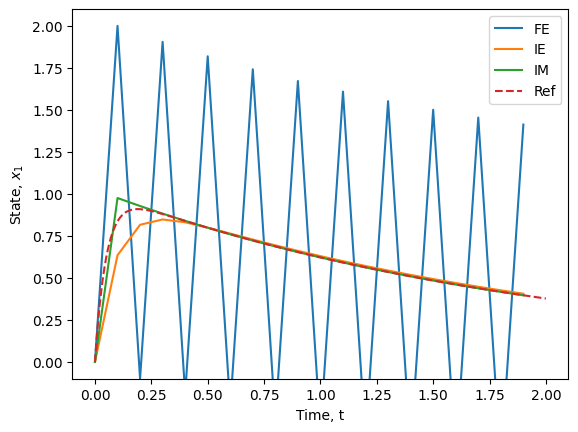

In [8]:
def f_stiff(t, x):
    return np.array([-.5 * x[0] + 20 * x[1],-20 * x[1]])

def Jf_stiff(t, x):
    return np.array([[-.5, 20], [0,-20]])

ics_stiff = np.array([0, 1.0])

def forward_euler_step_stiff(tn, _yn, h)-> np.ndarray:
    yn = _yn.copy()
    return yn + h * f_stiff(tn, yn).squeeze()

def implicit_euler_step_stiff(tn, xn, h):
    x = xn.copy()
    res = lambda t, x: x- xn- h*f_stiff(t, x)
    res_jac = lambda t, x: np.eye(len(x))- h * Jf_stiff(t, x)
    return newton(tn+h, x, res, res_jac)

def implicit_midpoint_step_stiff(tn, xn, h):
    x = xn.copy()
    res = lambda t, x: x- xn- h * f_stiff(t+h/2, (xn + x)/2)
    res_jac = lambda t, x: np.eye(len(x))- h/2 * Jf_stiff(t+h/2, (xn+x)/2)
    return newton(tn, x, res, res_jac)

t0, tf = 0, 2
h = .1
ts_fe_stiff, xs_fe_stiff = simulate_with_stepper(ics_stiff, t0, tf, h,forward_euler_step_stiff)
ts_be_stiff, xs_be_stiff = simulate_with_stepper(ics_stiff, t0, tf, h,implicit_euler_step_stiff)
ts_im_stiff, xs_im_stiff = simulate_with_stepper(ics_stiff, t0, tf, h,implicit_midpoint_step_stiff)
ts_ref,xs_ref = simulate_with_stepper(ics_stiff, t0, tf, 1e-4, implicit_euler_step_stiff)

plt.plot(ts_fe_stiff, xs_fe_stiff[0, :], label="FE")
plt.plot(ts_be_stiff, xs_be_stiff[0, :], label="IE")
plt.plot(ts_im_stiff, xs_im_stiff[0, :], label="IM")
plt.plot(ts_ref, xs_ref[0, :], label="Ref", linestyle="--")
plt.legend(); plt.xlabel("Time, t"); plt.ylabel("State, $x_1$")
plt.ylim(0-1e-1, 2+1e-1) # Setting the plot boundary

We may use the following principles to guide what sovler to choose:

    If we have a stiff problem, use an A-stable method.
    If it is really stiff, use an L-stable method.
    If we need to respect energy dissipativity/loss, use an implicit sovler.
    If we want to conserve energy, use a symplectic integrator.
    If we really need computational speed, use an explicit method.

This is not an exhaustive list, there are many other concerns.